# Exploratory Data Analysis

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from PIL import Image, ImageEnhance
import skimage.util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

In [3]:
def load_footwear_dataset(path, target_size=(128,128)):

    categories = ['Shoe','Sandal','Boot']   # Define the 3 categories we care about
    label_map = {c:i for i,c in enumerate(categories)}  # Map class name -> int label
    images, labels = [], []   # Lists to accumulate images and class labels

    # Loop over each category and load
    for cat in categories:
        cat_path = os.path.join(path, cat)
        # Get all files
        files = [f for f in os.listdir(cat_path) if f.lower().endswith(('jpg'))]
        print(f"{cat}: {len(files)} images")

        for f in files:
            img = cv2.imread(os.path.join(cat_path,f))   # read in BGR format
            if img is None: continue  # skip corrupt files
            img = cv2.resize(img, target_size)
            images.append(img)
            labels.append(label_map[cat])  # store numeric label

    # convert into numpy arrays
    images = np.stack(images).astype(np.uint8)   # Shape (N,H,W,C)
    labels = np.array(labels, dtype=np.int32)    # Shape (N,)
    print(f"\nLoaded {len(images)} images. Shape: {images.shape}")
    return images, labels, categories

In [9]:
dataset_path = "/content/fulldataset"
images, labels, categories = load_footwear_dataset(dataset_path)

Shoe: 5000 images
Sandal: 5000 images
Boot: 5000 images

Loaded 15000 images. Shape: (15000, 128, 128, 3)


Dataset is completely balanced, meets the requirements of the assignment as well.

In [4]:
def dataset_summary(images, labels, categories):
    print("Summary:")
    print("Total:", len(images))
    print("Distribution:", Counter(labels))   # nos. per class

    stats={}
    # computing brightness & edge sharpness info for each category
    for i,cat in enumerate(categories):
        idxs = np.where(labels==i)[0]  # indices of images in this category
        sample = images[idxs[:min(200, len(idxs))]]

        brightness=[]  # average pixel intensity
        edge_density=[]  # fraction of edge pixels (texture measure)

        for im in sample:
            gray=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)   # convert to grayscale
            brightness.append(np.mean(gray))   # mean intensity per image
            edges=cv2.Canny(gray,50,150)       # detect edges
            edge_density.append(np.mean(edges>0))  # % of non-zero edge pixels

        # save avgs per category
        stats[cat] = {
            "brightness": np.mean(brightness),
            "edge_density": np.mean(edge_density)
        }
        print(f"{cat}: avg brightness={stats[cat]['brightness']:.1f}, edge density={stats[cat]['edge_density']:.3f}")
    return stats

In [10]:
stats = dataset_summary(images, labels, categories)

Summary:
Total: 15000
Distribution: Counter({np.int32(0): 5000, np.int32(1): 5000, np.int32(2): 5000})
Shoe: avg brightness=194.2, edge density=0.088
Sandal: avg brightness=203.9, edge density=0.088
Boot: avg brightness=200.7, edge density=0.072


Sandals are brighter overall.

Boots have lowest edge density.

Shoes fall in between.

In [5]:
def plot_color_histograms(images, labels, categories, sample_per_class=200):

    # Builds histogram plots of HSV channels for each class
    plt.figure(figsize=(12,6))
    for i,cat in enumerate(categories):
        idxs = np.where(labels==i)[0]

        # random subset choice
        idxs = np.random.choice(idxs, size=min(sample_per_class, len(idxs)), replace=False)
        hsv_vals = []
        for idx in idxs:
            hsv = cv2.cvtColor(images[idx], cv2.COLOR_BGR2HSV)
            hsv_vals.append(np.mean(hsv, axis=(0,1)))  # avg hue, sat, val
        hsv_vals = np.array(hsv_vals)

        plt.subplot(1, len(categories), i+1)

        plt.hist(hsv_vals[:,0], bins=30, color='red', alpha=0.6, label='Hue')
        plt.hist(hsv_vals[:,1], bins=30, color='green', alpha=0.6, label='Saturation')
        plt.hist(hsv_vals[:,2], bins=30, color='blue', alpha=0.6, label='Value')
        plt.title(f"{cat} HSV dist"); plt.xlabel("Value"); plt.ylabel("Count")
        plt.legend()
    plt.tight_layout()
    plt.show()

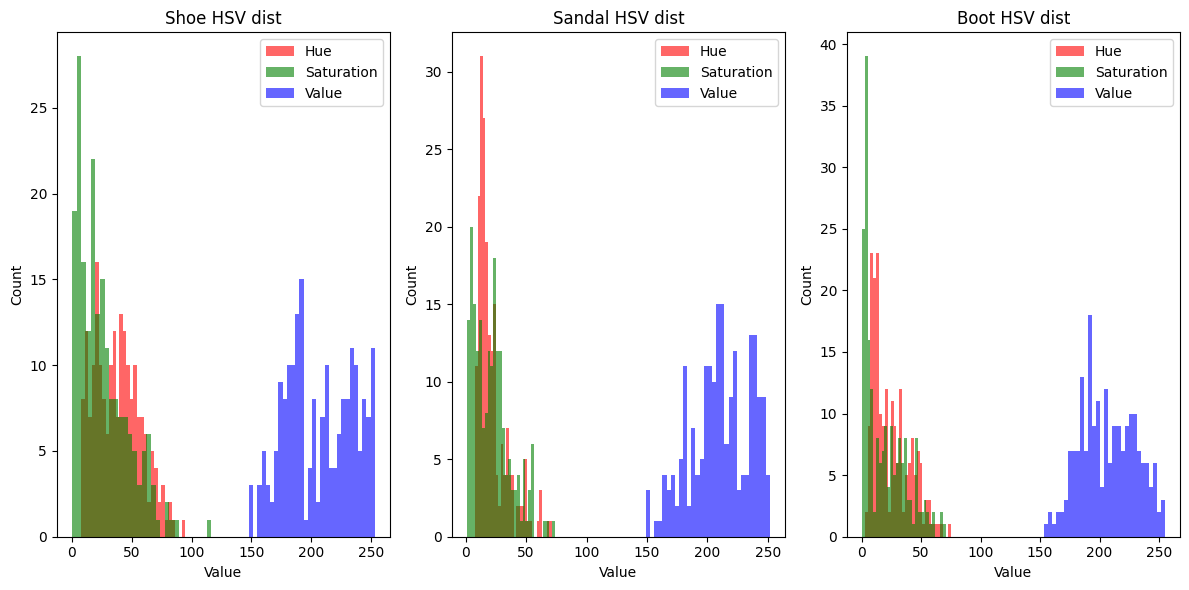

In [11]:
plot_color_histograms(images, labels, categories, sample_per_class=200)

In [6]:
def plot_class_balance(labels, categories):
    counts = Counter(labels)
    plt.figure(figsize=(5,4))
    sns.barplot(x=list(categories),
                y=[counts[i] for i in range(len(categories))],
                palette="pastel")
    plt.title("Class Distribution")
    plt.ylabel("Image Count"); plt.show()

/tmp/ipython-input-4211784672.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(categories),


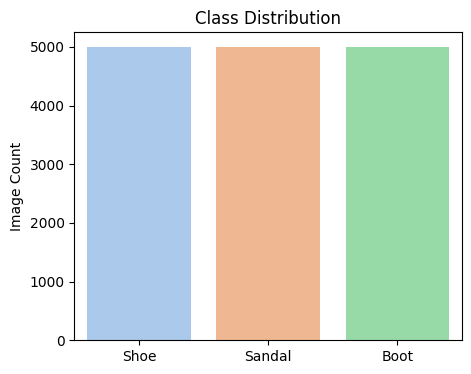

In [13]:
plot_class_balance(labels, categories)

In [18]:
def check_image_quality(images, threshold_low=50):
    # computing mean brightness for each image
    avg_brightness = [np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) for img in images]

    dark = [i for i,b in enumerate(avg_brightness) if b < threshold_low]

    print(f"Extremely dark images: {len(dark)}")
    return dark

In [19]:
dark = check_image_quality(images)

Extremely dark images: 0


No extremely dark images, due to white backgrounds in product photography.

Models may rely excessively on background brightness, not footwear details, must be explored in preprocessing.

In [20]:
def plot_dominant_colors(images, labels, categories, n_colors=5, sample_size=5000):
    plt.figure(figsize=(10,3))
    for i, cat in enumerate(categories):
        idxs = np.where(labels == i)[0]

        # collect pixels from multiple images (not just 1 random one)
        all_pixels = []
        for idx in idxs:
            img = cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB)
            all_pixels.append(img.reshape((-1, 3)))

        # stack into a single array: shape = (total_pixels, 3)
        all_pixels = np.vstack(all_pixels)

        if len(all_pixels) > sample_size:
            chosen_idx = np.random.choice(len(all_pixels), sample_size, replace=False)
            all_pixels = all_pixels[chosen_idx]

        # run k-means on all (sampled) pixels
        kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(all_pixels)
        centers = kmeans.cluster_centers_.astype(int)

        # draw swatch of dominant colors
        plt.subplot(1, len(categories), i+1)
        swatch = np.zeros((50, 300, 3), dtype=np.uint8)
        step = 300 // n_colors
        for j, col in enumerate(centers):
            swatch[:, j*step:(j+1)*step] = col
        plt.imshow(swatch)
        plt.title(f"{cat} colors")
        plt.axis("off")

    plt.suptitle("Dominant Color Palettes per Category")
    plt.show()

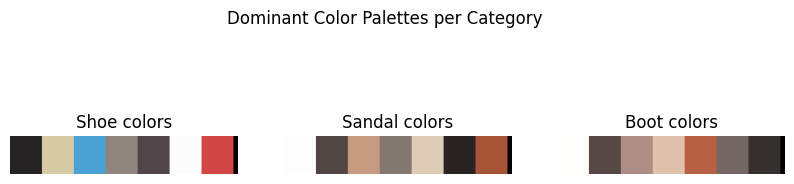

In [21]:
plot_dominant_colors(images, labels, categories, n_colors=7)

Shoe: Palette has darker greys, reds, beige, suggests shoes in dataset have more varied colors.

Sandal: Dominated by browns and beige indicates sandals tend to be lighter/earthy colored.

Boot: Mostly darker browns/greys with some beige, fairly monotone and muted.